# Preparing MTA Bridge and Tunnel Toll Data

Imputing missing data and preparing vehicle activity index.

In [1]:
import matplotlib.pyplot as plt
import pandahelper as ph
import pandas as pd
from sklearn import (
    dummy,
    linear_model,
    model_selection,
    preprocessing,
    pipeline,
    compose,
    metrics,
)
import xgboost as xgb
from src.constants import MONTHS_MAP
import src.strings
import src.utils
import src.visualizations as viz

## Parameters

In [2]:
DATA_LOC = "data/raw/mta/Hourly_Traffic_MTA.csv"
PLAZA_MAPPING_LOC = "data/Plaza ID Mapping.csv"
PROCESSED_DATA_LOC = "data/processed/traffic_index.pkl"
MILLION = 1000000

## Helper Functions

In [3]:
def datetimeindex_features(df):
    """Return pd.DataFrame of time components as features."""
    x = pd.DataFrame()
    x["year"] = df.index.year
    x["month"] = df.index.month
    x["day"] = df.index.day
    x["dayofweek"] = df.index.dayofweek
    x["hour"] = df.index.hour
    return x


def preprocess(x, y, sparse=True):
    """Prepare and return Column Transformer fit on input cartegorical data."""
    cat_features = [
        "year",
        "month",
        "day",
        "dayofweek",
        "hour",
        "Location",
    ]
    transformations = []
    for feature in cat_features:
        pipe = pipeline.make_pipeline(
            preprocessing.OneHotEncoder(
                handle_unknown="infrequent_if_exist", sparse_output=sparse
            )
        )
        transformations.append((feature, pipe, [feature]))
    col_transformer = compose.ColumnTransformer(
        transformations,
        remainder="passthrough",
    )
    col_transformer.fit(x, y)
    return col_transformer

## Mapping Plaza ID to Name of Crossing

In [4]:
data = pd.read_csv(DATA_LOC)
data.head()

Plaza ID        Date  Hour Direction  # Vehicles - E-ZPass  \
0        21  05/30/2024     0         I                  2021   
1        21  05/30/2024     1         I                  1187   
2        21  05/30/2024     2         I                   880   
3        21  05/30/2024     3         I                   852   
4        21  05/30/2024     4         I                  1698   

   # Vehicles - VToll  
0                 413  
1                 281  
2                 218  
3                 203  
4                 321

In [5]:
plaza_location_info = pd.read_csv(PLAZA_MAPPING_LOC)
plaza_location_info

Plaza ID                                  Bridge / Tunnel   Latitude  \
0         21                         Robert F. Kennedy Bridge  40.779648   
1         22                         Robert F. Kennedy Bridge  40.779648   
2         23                    Bronx-Whitestone Bridge (BWB)  40.801405   
3         24                        Henry Hudson Bridge (HHB)  40.877645   
4         25  Marine Parkway-Gil Hodges Memorial Bridge (MPB)  40.573195   
5         26         Cross Bay Veterans Memorial Bridge (CBB)  40.597142   
6         27                      Queens Midtown Tunnel (QMT)  40.745490   
7         28                       Hugh L. Carey Tunnel (HCT)  40.694049   
8         29                         Throgs Neck Bridge (TNB)  40.799901   
9         30                  Verrazzano-Narrows Bridge (VNB)  40.606461   
10         1                         Robert F. Kennedy Bridge  40.779648   
11         2                         Robert F. Kennedy Bridge  40.779648   
12         3                    Bronx-Whitestone Bridge (BWB)  40.801405   
13         4                        Henry Hudson Bridge (HHB)  40.877645   
14         5  Marine Parkway-Gil Hodges Memorial Bridge (MPB)  40.573195   
15         6         Cross Bay Veterans Memorial Bridge (CBB)  40.597142   
16         7                      Queens Midtown Tunnel (QMT)  40.745490   
17         8                       Hugh L. Carey Tunnel (HCT)  40.694049   
18         9                         Throgs Neck Bridge (TNB)  40.799901   
19        11                  Verrazzano-Narrows Bridge (VNB)  40.606461   

    Longitude  
0  -73.926771  
1  -73.926771  
2  -73.829348  
3  -73.922386  
4  -73.884734  
5  -73.820928  
6  -73.964421  
7  -74.012872  
8  -73.793407  
9  -74.045057  
10 -73.926771  
11 -73.926771  
12 -73.829348  
13 -73.922386  
14 -73.884734  
15 -73.820928  
16 -73.964421  
17 -74.012872  
18 -73.793407  
19 -74.045057

In [6]:
plaza_bridge_map = dict(
    zip(plaza_location_info["Plaza ID"], plaza_location_info["Bridge / Tunnel"])
)
data["Location"] = data["Plaza ID"].map(plaza_bridge_map)

In [7]:
data.head()

Plaza ID        Date  Hour Direction  # Vehicles - E-ZPass  \
0        21  05/30/2024     0         I                  2021   
1        21  05/30/2024     1         I                  1187   
2        21  05/30/2024     2         I                   880   
3        21  05/30/2024     3         I                   852   
4        21  05/30/2024     4         I                  1698   

   # Vehicles - VToll                  Location  
0                 413  Robert F. Kennedy Bridge  
1                 281  Robert F. Kennedy Bridge  
2                 218  Robert F. Kennedy Bridge  
3                 203  Robert F. Kennedy Bridge  
4                 321  Robert F. Kennedy Bridge

## Adding Datetime Index

In [8]:
data["date hour"] = data["Date"] + " " + data["Hour"].astype(dtype="str")
data["datetime"] = pd.to_datetime(data["date hour"], format="%m/%d/%Y %H")
data = data.drop(["date hour"], axis=1)
data = data.set_index("datetime")

In [9]:
data.head()

Plaza ID        Date  Hour Direction  \
datetime                                                    
2024-05-30 00:00:00        21  05/30/2024     0         I   
2024-05-30 01:00:00        21  05/30/2024     1         I   
2024-05-30 02:00:00        21  05/30/2024     2         I   
2024-05-30 03:00:00        21  05/30/2024     3         I   
2024-05-30 04:00:00        21  05/30/2024     4         I   

                     # Vehicles - E-ZPass  # Vehicles - VToll  \
datetime                                                        
2024-05-30 00:00:00                  2021                 413   
2024-05-30 01:00:00                  1187                 281   
2024-05-30 02:00:00                   880                 218   
2024-05-30 03:00:00                   852                 203   
2024-05-30 04:00:00                  1698                 321   

                                     Location  
datetime                                       
2024-05-30 00:00:00  Robert F. Kennedy Bridge  
2024-05-30 01:00:00  Robert F. Kennedy Bridge  
2024-05-30 02:00:00  Robert F. Kennedy Bridge  
2024-05-30 03:00:00  Robert F. Kennedy Bridge  
2024-05-30 04:00:00  Robert F. Kennedy Bridge

## Adding Single Vehicle Count Field

In [10]:
data["Sum Vehicles"] = data["# Vehicles - E-ZPass"] + data["# Vehicles - VToll"]

In [11]:
data.index.max()

Timestamp('2024-05-30 23:00:00')

## Imputation of Missing Data

In [12]:
counts_loc = (
    data.groupby(by=["datetime", "Location"])["Sum Vehicles"]
    .sum()
    .reset_index("Location")
)

### Comparing Models

Preparing data

In [13]:
y_scaler = preprocessing.StandardScaler()
y = y_scaler.fit_transform(pd.DataFrame(counts_loc["Sum Vehicles"]))
raw_x = datetimeindex_features(counts_loc)
raw_x["Location"] = counts_loc["Location"].values
col_transformer = preprocess(raw_x, y)
x = col_transformer.transform(raw_x)

Separating test data

In [14]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.1, random_state=2
)

XGBoost seems to outperform Ordinary Least Squares (OLS) and a null model

In [15]:
# null_model - always guess mean
null = dummy.DummyRegressor(strategy="mean")
null_results = model_selection.cross_validate(
    null, x_train, y_train, scoring="neg_mean_squared_error", cv=5
)
print(f"Null model: {null_results["test_score"].mean()}")

# OLS Transformed features
ols = linear_model.LinearRegression()
ols_results = model_selection.cross_validate(
    ols, x_train, y_train, scoring="neg_mean_squared_error", cv=5
)
print(f"Transformed OLS: {ols_results["test_score"].mean()}")

# XGBoost
gb = xgb.XGBRegressor(
    learning_rate=0.07, n_estimators=1400, subsample=0.6, max_depth=13
)
gb_results = model_selection.cross_validate(
    gb, x_train, y_train, scoring="neg_mean_squared_error", cv=5
)
print(f"XGBoost: {gb_results["test_score"].mean()}\n")

Null model: -1.0010165238136473
Transformed OLS: -0.23714971821903846
XGBoost: -0.013521713900977289



In [16]:
gb_params = {
    "learning_rate": [0.07],
    "n_estimators": [1400, 1600],
    "max_depth": [15, 16],
    "subsample": [0.6, 0.7],
}
results = src.utils.search_grid(
    x_train, y_train, xgb.XGBRegressor, gb_params, "neg_mean_squared_error"
)

Mean Score 	Run Time(min) 	Parameters
-0.0133		9.387		{'learning_rate': 0.07, 'max_depth': 15, 'n_estimators': 1400, 'subsample': 0.6}
-0.0132		9.545		{'learning_rate': 0.07, 'max_depth': 15, 'n_estimators': 1400, 'subsample': 0.7}
-0.0132		11.002		{'learning_rate': 0.07, 'max_depth': 15, 'n_estimators': 1600, 'subsample': 0.6}
-0.0132		11.107		{'learning_rate': 0.07, 'max_depth': 15, 'n_estimators': 1600, 'subsample': 0.7}
-0.0132		10.791		{'learning_rate': 0.07, 'max_depth': 16, 'n_estimators': 1400, 'subsample': 0.6}
-0.0131		11.703		{'learning_rate': 0.07, 'max_depth': 16, 'n_estimators': 1400, 'subsample': 0.7}
-0.0132		12.482		{'learning_rate': 0.07, 'max_depth': 16, 'n_estimators': 1600, 'subsample': 0.6}
-0.0131		12.491		{'learning_rate': 0.07, 'max_depth': 16, 'n_estimators': 1600, 'subsample': 0.7}

Best score: -0.013144146501518687
Best parameters: {'learning_rate': 0.07, 'max_depth': 16, 'n_estimators': 1400, 'subsample': 0.7}



In [17]:
gb = xgb.XGBRegressor(
    learning_rate=0.07, n_estimators=1600, max_depth=16, subsample=0.7
)
gb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Checking model performance against test data

In [18]:
metrics.mean_squared_error(y_test, gb.predict(x_test))

0.012623191998460875

### Imputing Missing Data Using XGBoost

In [19]:
imputed = []
for location in counts_loc["Location"].unique():
    crossing = counts_loc[counts_loc["Location"] == location]
    gaps = ph.id_gaps_index(
        crossing, pd.Timedelta(hours=3)
    )  # ignore small gaps due to DST, etc.
    gaps["start"] = gaps.index - (
        gaps["diffs"] - pd.Timedelta(hours=1)
    )  # next time unit after last observation
    for idx, row in gaps.iterrows():
        dr = pd.date_range(row["start"], idx, inclusive="left", freq="h")
        df = pd.DataFrame({"Location": [location] * len(dr)}, index=dr)
        raw_x = datetimeindex_features(df)
        raw_x["Location"] = df["Location"].values
        x = col_transformer.transform(raw_x)
        y_pred = gb.predict(x)
        # predicted values should never be < 0
        y_inverse = [
            max(0, round(y))
            for y in y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        ]
        df["Sum Vehicles"] = pd.Series(y_inverse, index=dr)
        imputed.append(df)

In [20]:
imputed_df = pd.concat(imputed)

### Compare Imputed Values to Population Values
The distribution of imputed values is similar to the population distribution.

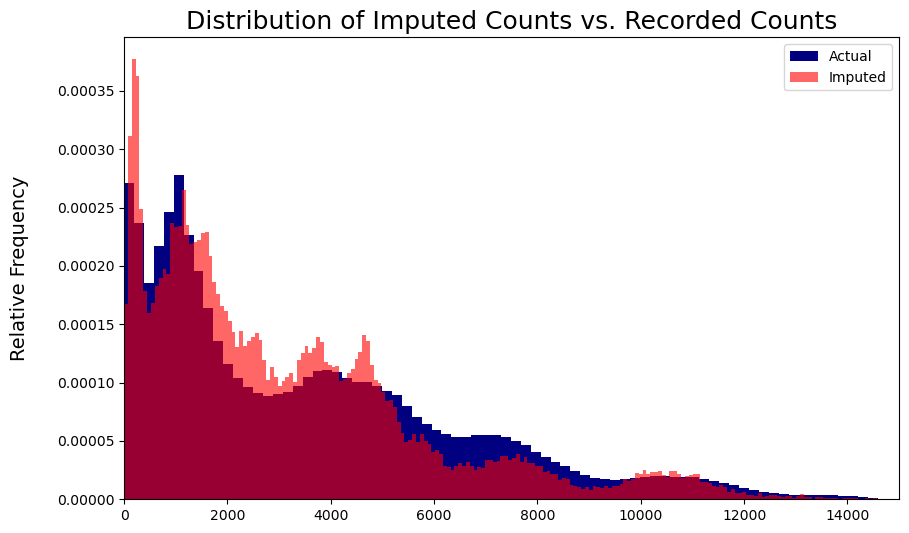

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(
    counts_loc["Sum Vehicles"], bins=200, density=True, label="Actual", color="navy"
)
plt.hist(
    imputed_df["Sum Vehicles"],
    bins=200,
    density=True,
    label="Imputed",
    alpha=0.6,
    color="red",
)
plt.xlim((0, 15000))
plt.title("Distribution of Imputed Counts vs. Recorded Counts", fontsize=18)
plt.ylabel("Relative Frequency", labelpad=20, fontsize=14)
plt.legend()
plt.show()

### Compare Population and Imputed Values per Crossing
The imputed values per crossing appear to match the recorded values.

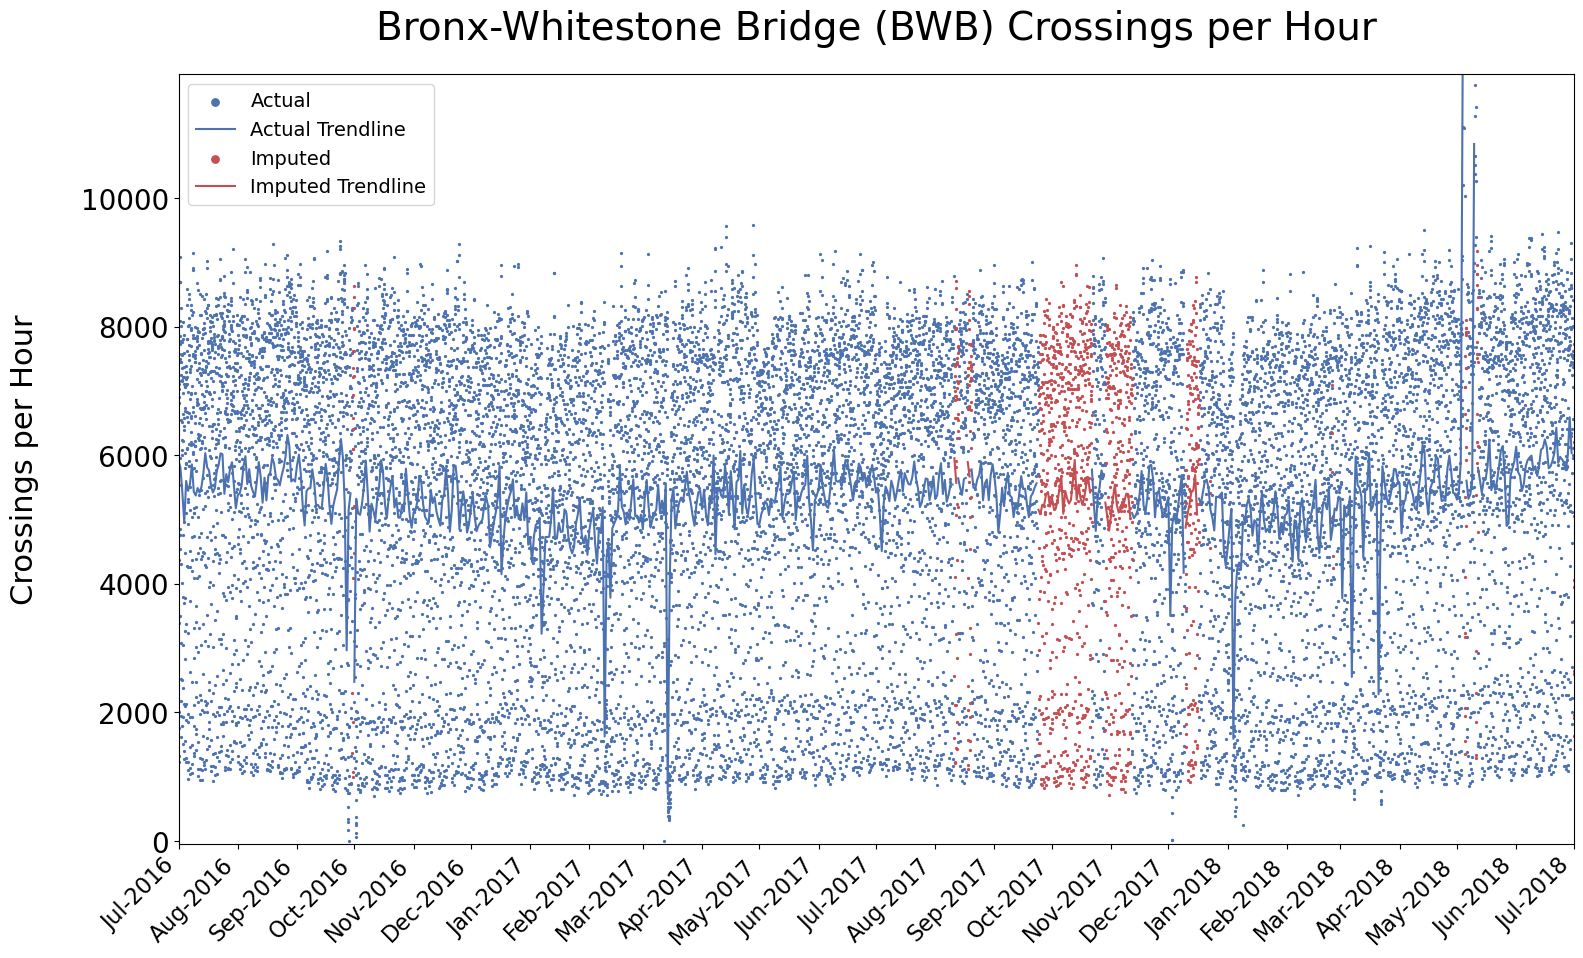

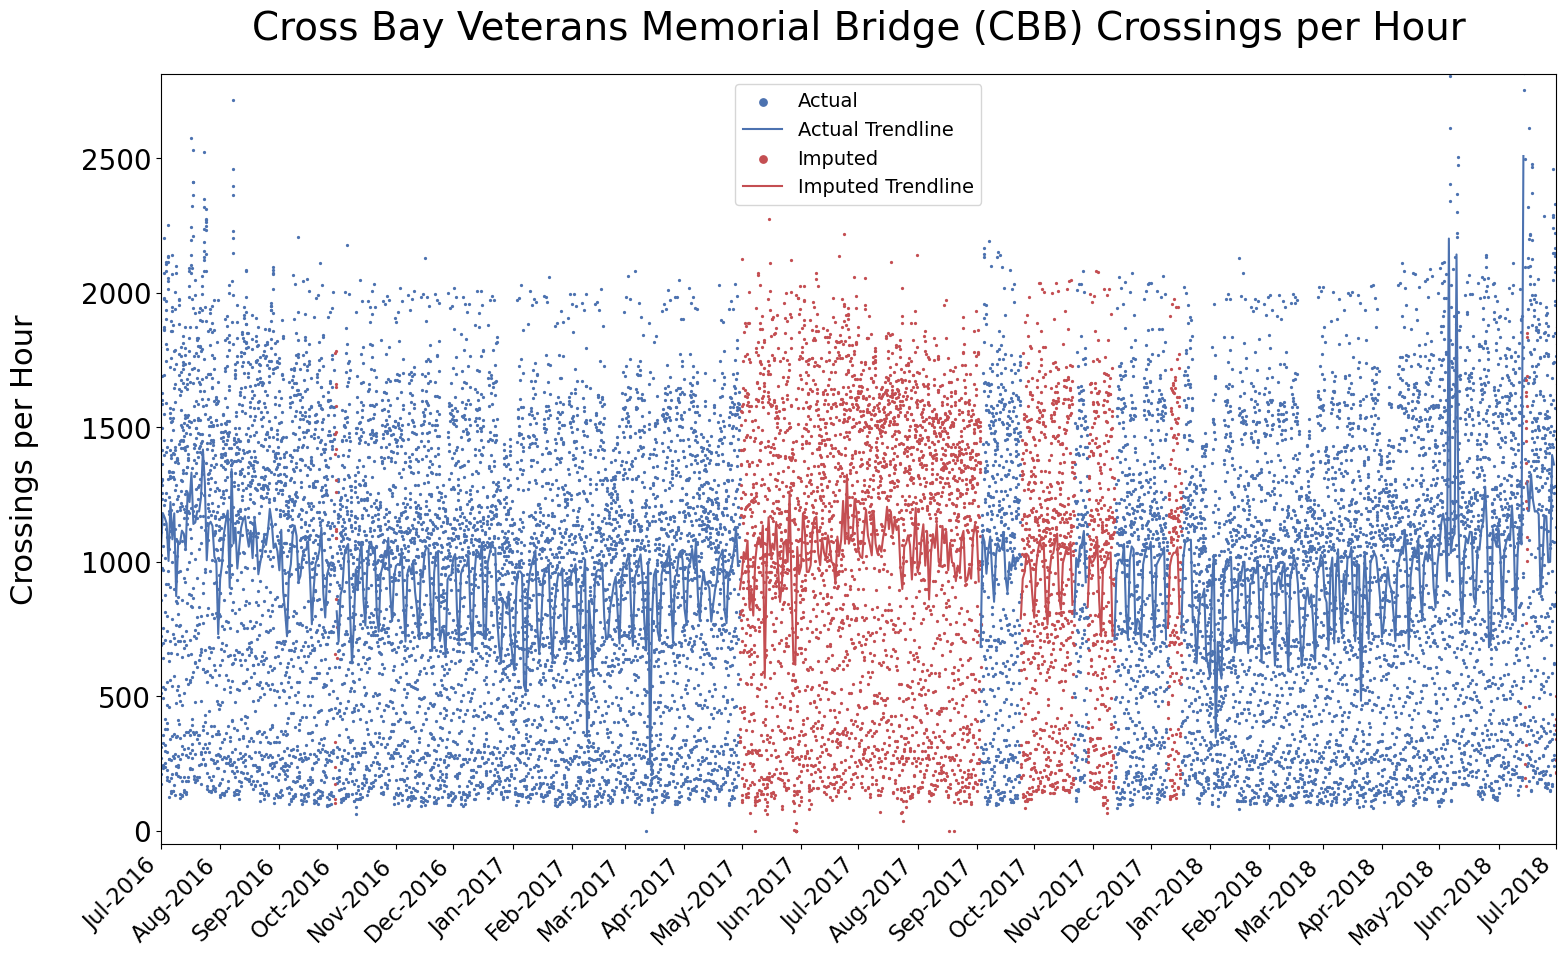

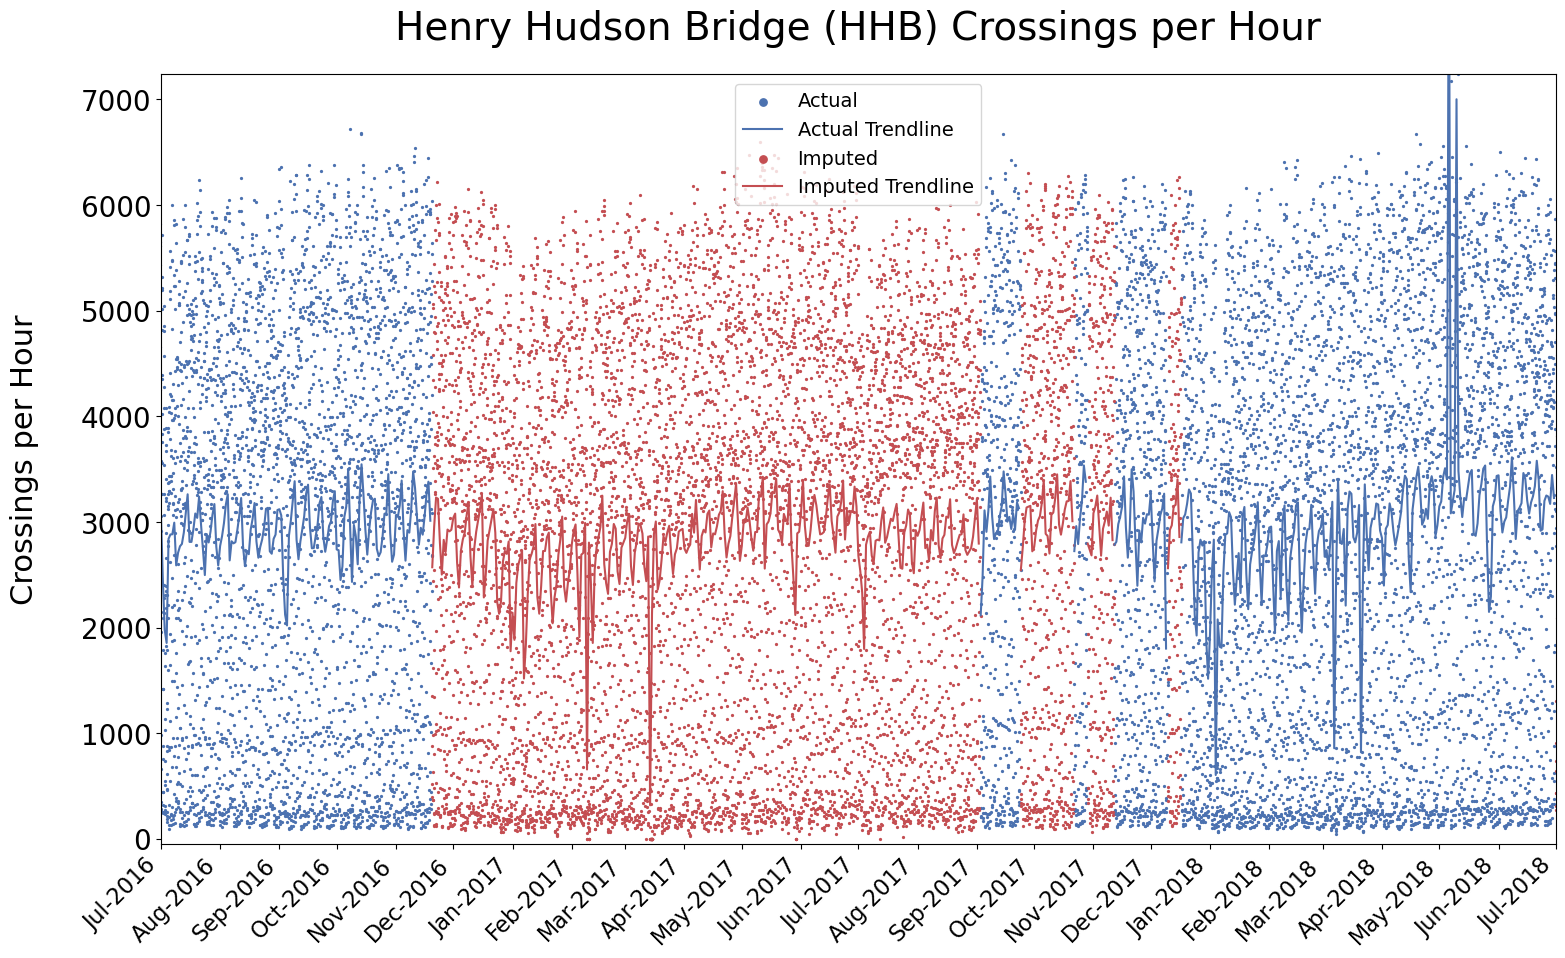

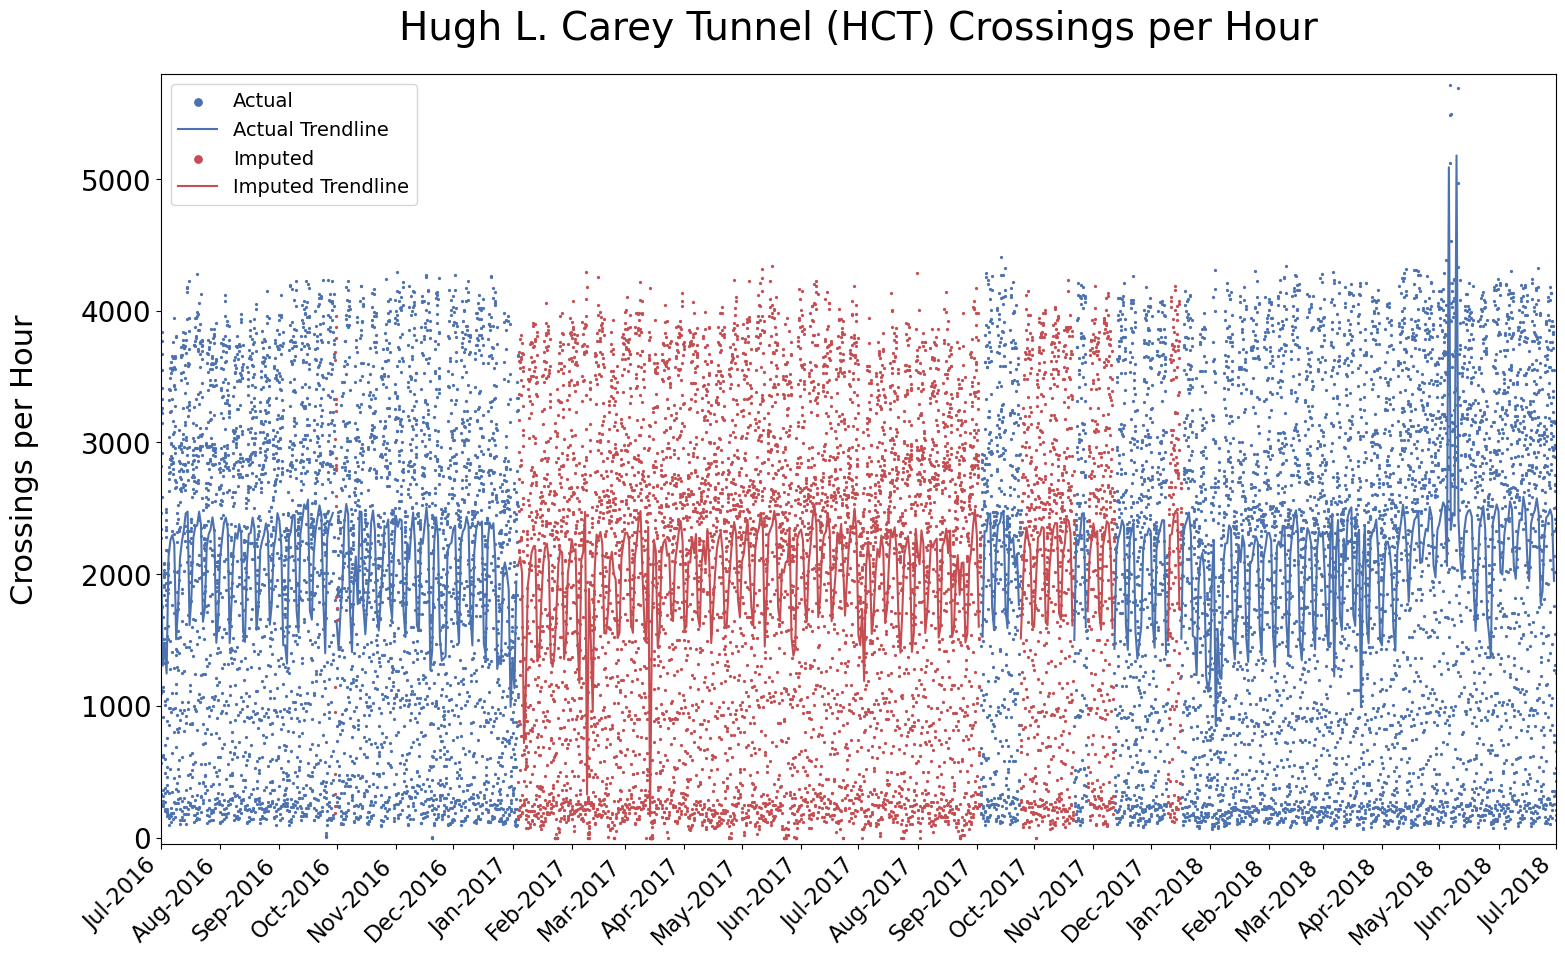

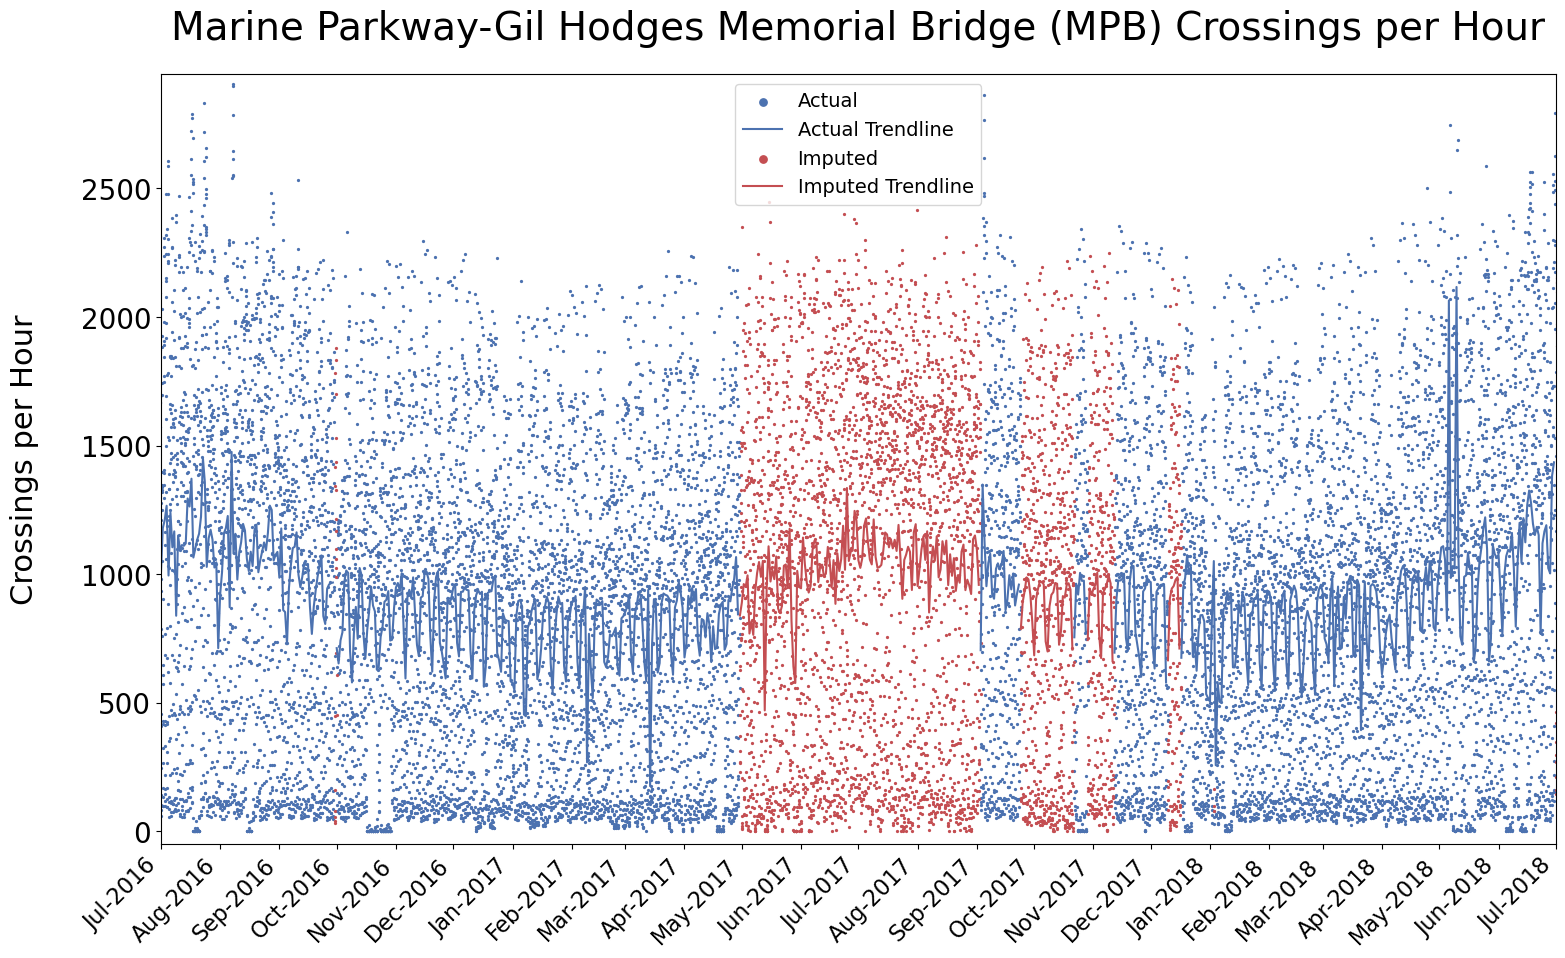

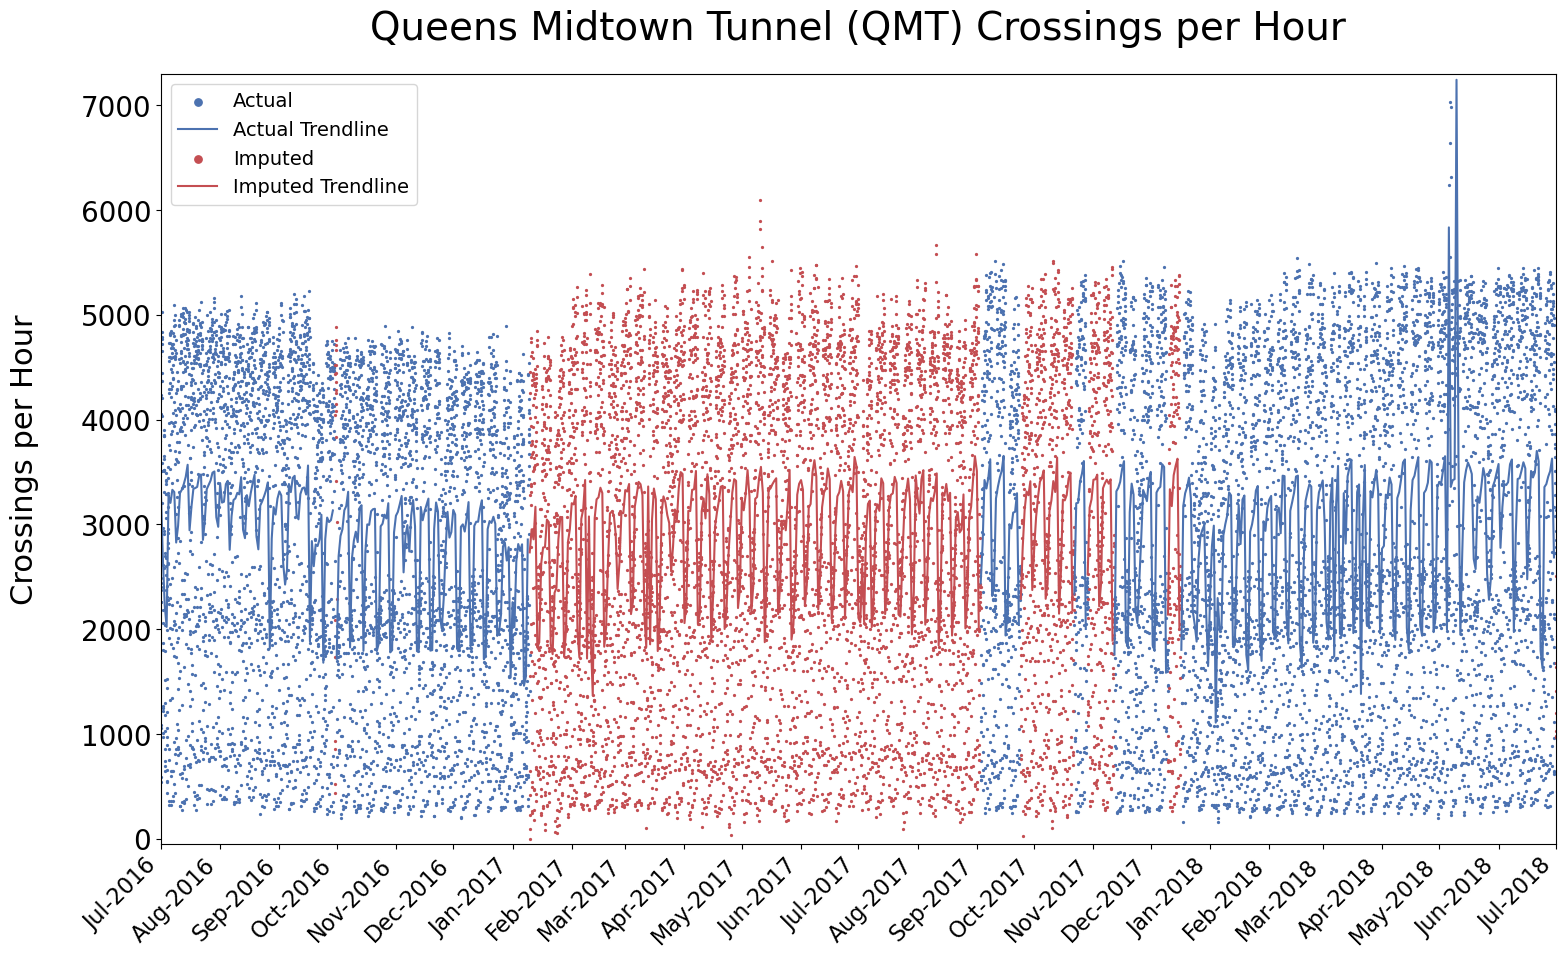

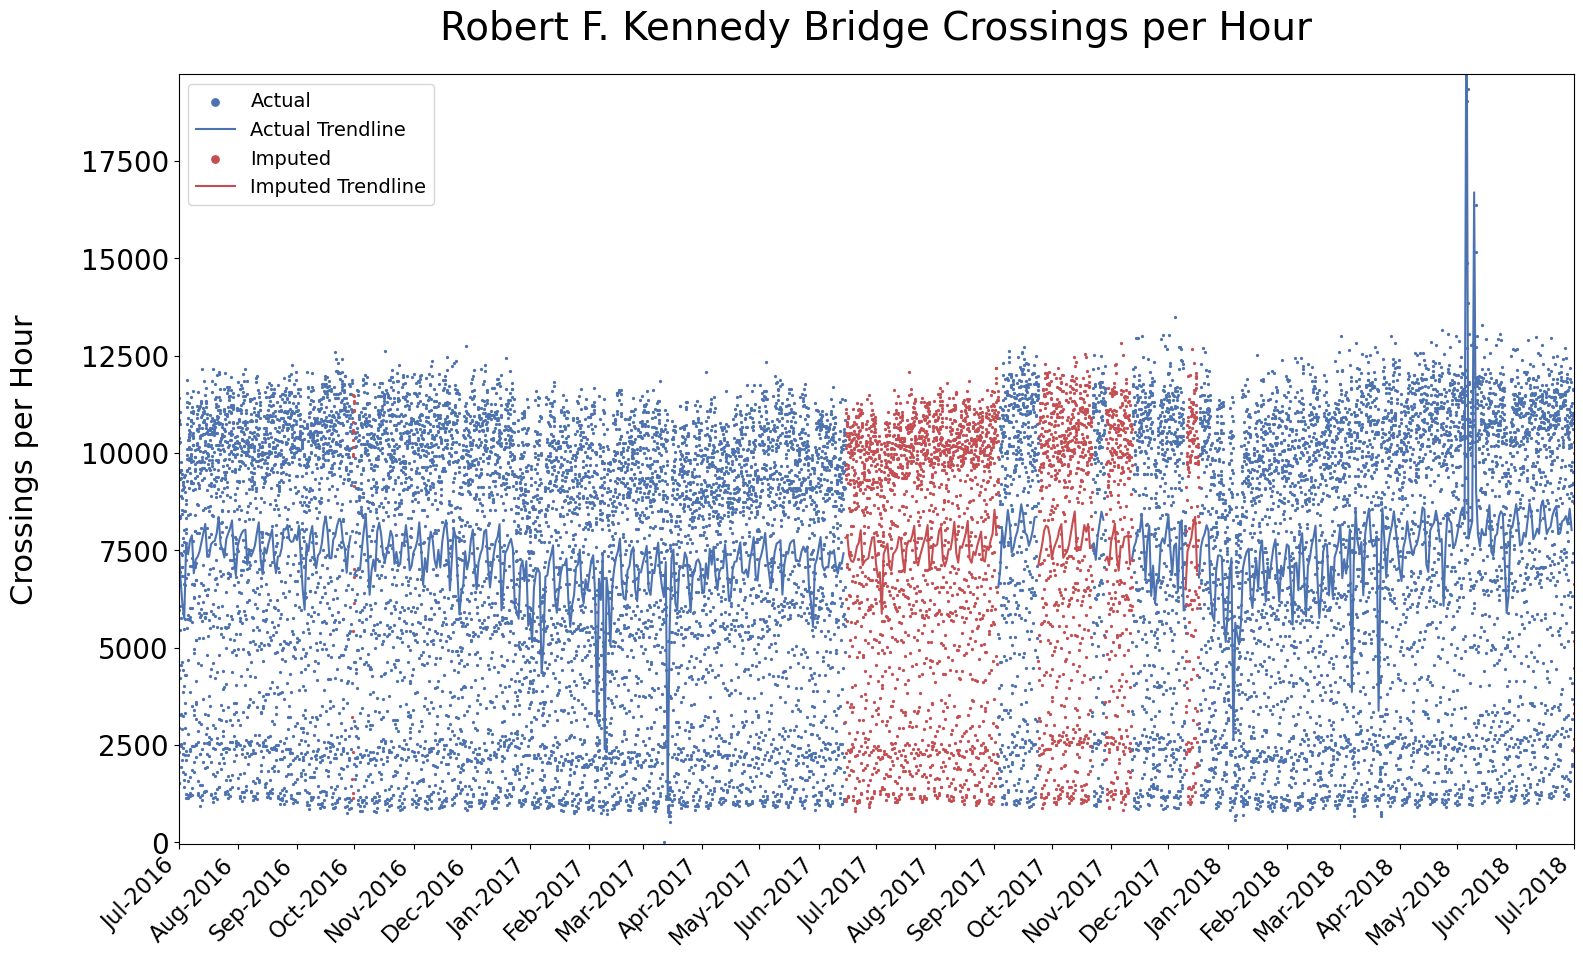

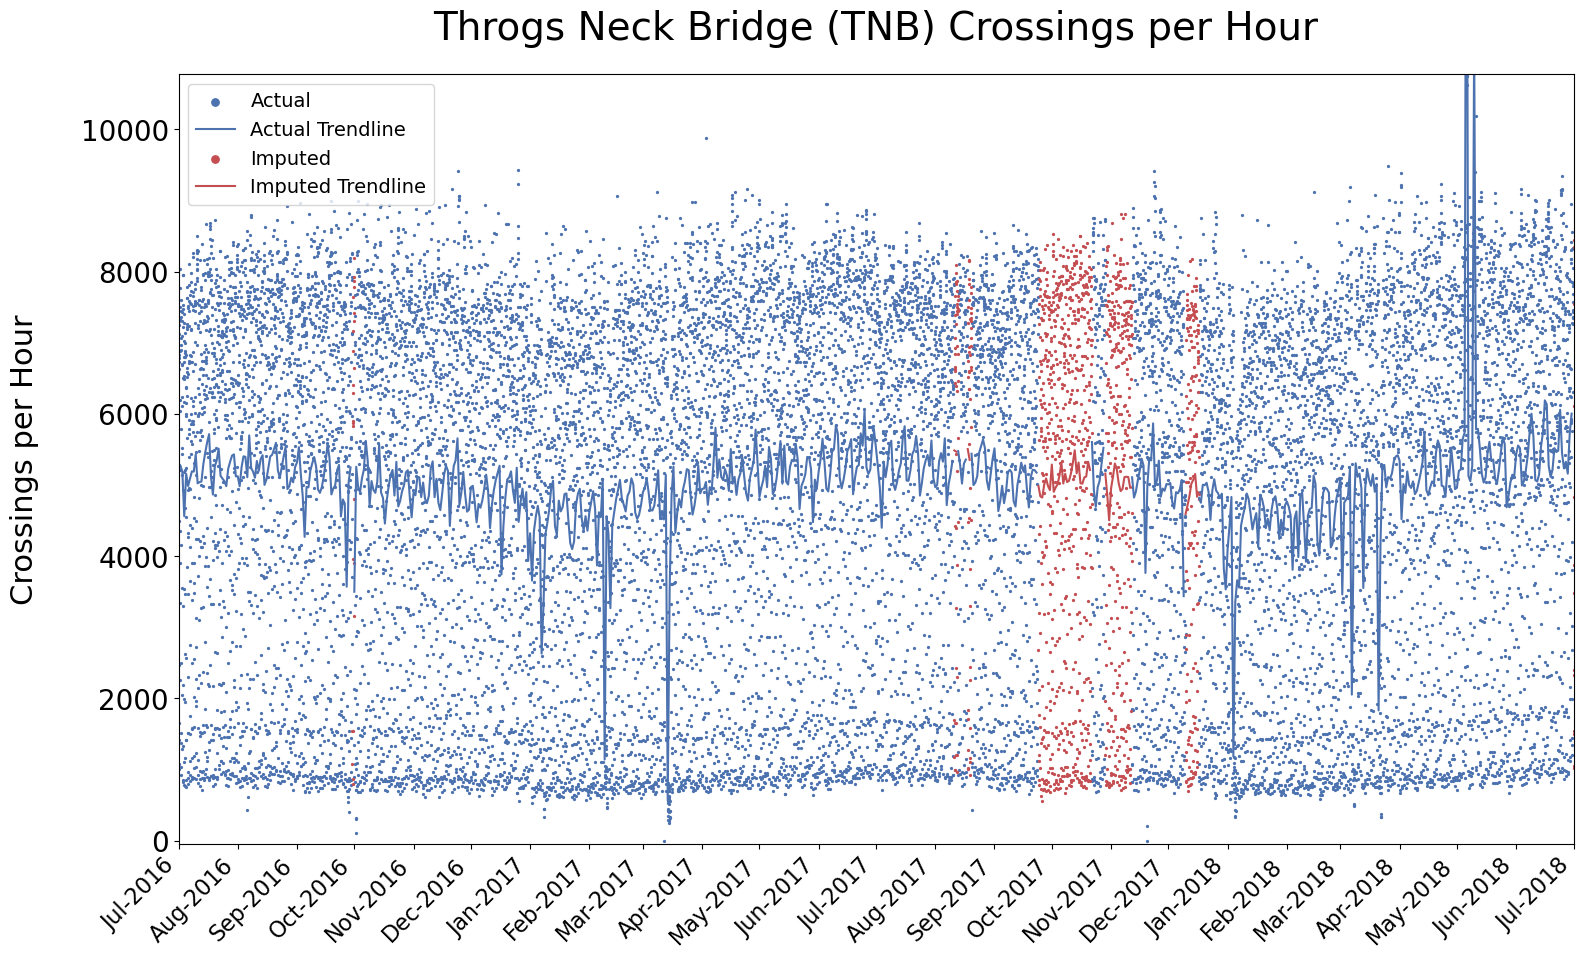

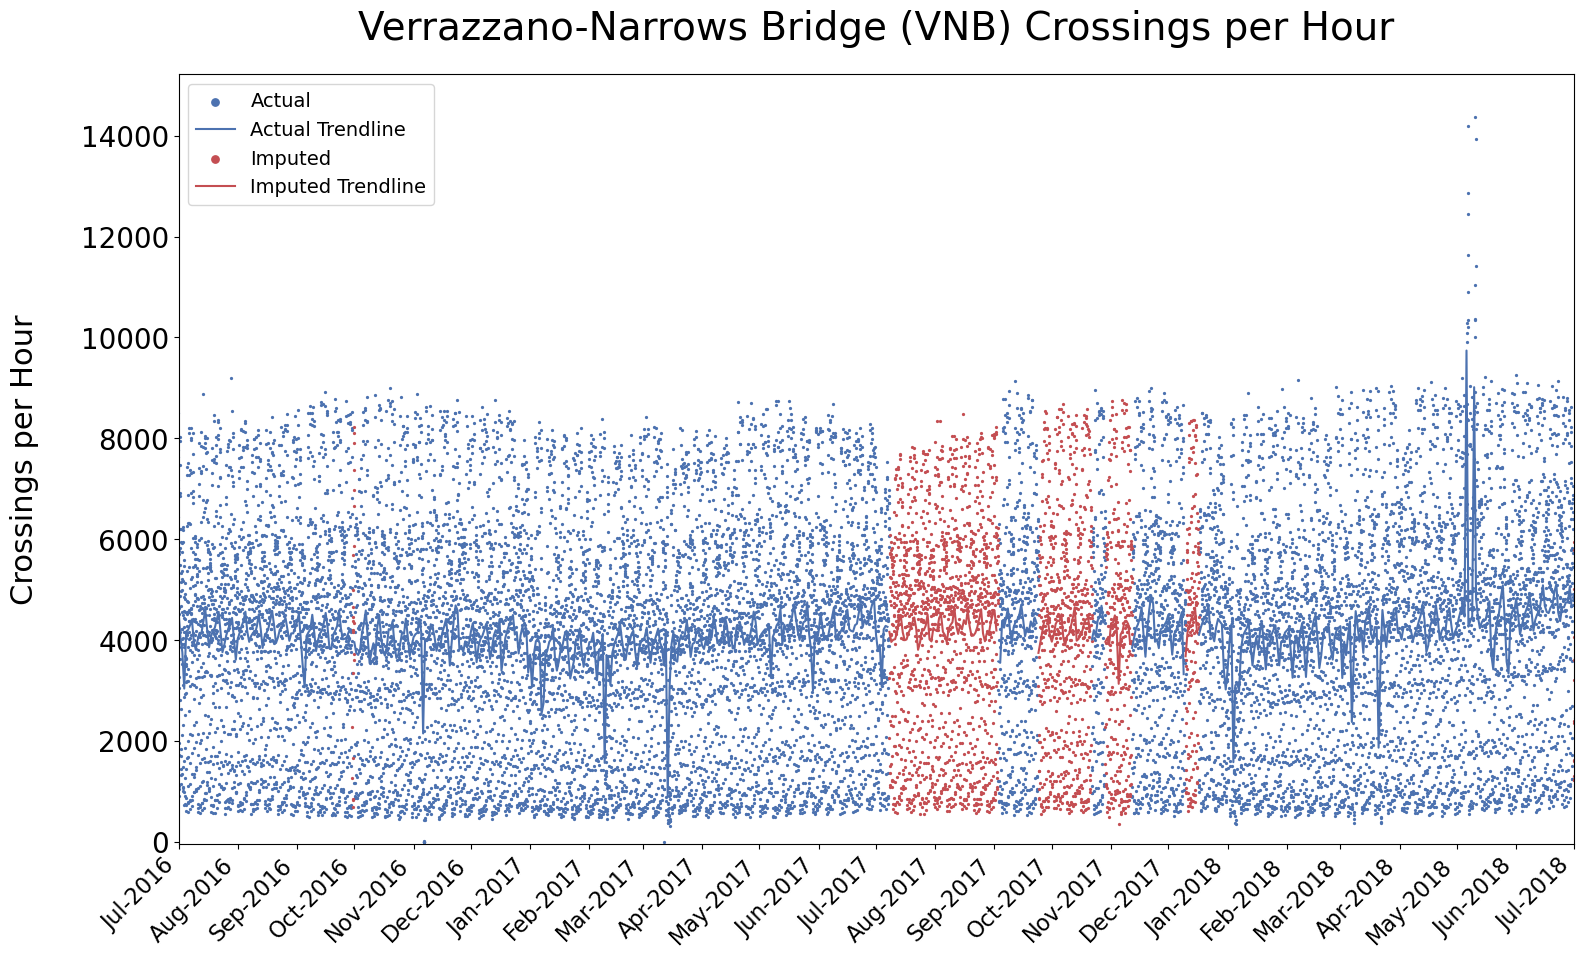

In [22]:
for location in counts_loc["Location"].unique():
    crossing = counts_loc[counts_loc["Location"] == location]
    daily_mean = crossing.resample("d")["Sum Vehicles"].mean()
    imp_crossing = imputed_df[imputed_df["Location"] == location]
    daily_mean_imp = imp_crossing.resample("d")["Sum Vehicles"].mean()

    xticks = pd.date_range(
        pd.Timestamp(year=2016, month=7, day=1), periods=25, freq="MS"
    )
    xlabels = [f"{MONTHS_MAP[x.month]}-{x.year}" for x in xticks]
    scatter_params = {
        "title": f"{location} Crossings per Hour",
        "ylabel": "Crossings per Hour",
        "ylabel_rotation": "vertical",
        "xlim": (
            pd.Timestamp(year=2016, month=7, day=1),
            pd.Timestamp(year=2018, month=7, day=1),
        ),
        "ylim": (-50, crossing["Sum Vehicles"].quantile(0.9997)),
        "xticks": {
            "ticks": xticks,
            "labels": xlabels,
            "rotation": 45,
            "ha": "right",
            "fontsize": 16,
        },
    }
    with plt.style.context("default"):
        fig, ax = viz.setup_chart(**scatter_params)
        ax.scatter(
            crossing.index,
            crossing["Sum Vehicles"].values,
            s=7,
            marker=".",
            label="Actual",
        )
        ax.plot(daily_mean.index, daily_mean.values, label="Actual Trendline")
        ax.scatter(
            imp_crossing.index,
            imp_crossing["Sum Vehicles"].values,
            s=7,
            marker=".",
            label="Imputed",
        )
        ax.plot(daily_mean_imp.index, daily_mean_imp.values, label="Imputed Trendline")
        ax.legend(fontsize=14, markerscale=4)
        plt.show()

The mean, median, and standard deviation of the imputed values is generally comparable to the population values.

In [23]:
locations = []
means = []
medians = []
stdevs = []
for location in counts_loc["Location"].unique():
    crossing = counts_loc[counts_loc["Location"] == location]
    crossing = crossing[(crossing.index.year >= 2015) & (crossing.index.year <= 2019)]
    imp_crossing = imputed_df[imputed_df["Location"] == location]

    diff_median = (
        imp_crossing["Sum Vehicles"].median() - crossing["Sum Vehicles"].median()
    ) / crossing["Sum Vehicles"].median()
    diff_mean = (
        imp_crossing["Sum Vehicles"].mean() - crossing["Sum Vehicles"].mean()
    ) / crossing["Sum Vehicles"].mean()
    diff_sd = (
        imp_crossing["Sum Vehicles"].std() - crossing["Sum Vehicles"].std()
    ) / crossing["Sum Vehicles"].std()

    locations.append(location)
    medians.append(f"{diff_median*100:.2f}%")
    means.append(f"{diff_mean*100:.2f}%")
    stdevs.append(f"{diff_sd*100:.2f}%")
diffs = pd.DataFrame(
    {
        "Median Difference": medians,
        "Mean Difference": means,
        "Standard Deviation Difference": stdevs,
    },
    index=locations,
)
diffs

Median Difference  \
Bronx-Whitestone Bridge (BWB)                               7.79%   
Cross Bay Veterans Memorial Bridge (CBB)                    9.26%   
Henry Hudson Bridge (HHB)                                   3.15%   
Hugh L. Carey Tunnel (HCT)                                 -3.11%   
Marine Parkway-Gil Hodges Memorial Bridge (MPB)            13.73%   
Queens Midtown Tunnel (QMT)                               -17.88%   
Robert F. Kennedy Bridge                                    7.68%   
Throgs Neck Bridge (TNB)                                    1.34%   
Verrazzano-Narrows Bridge (VNB)                            13.06%   

                                                Mean Difference  \
Bronx-Whitestone Bridge (BWB)                             5.99%   
Cross Bay Veterans Memorial Bridge (CBB)                  5.94%   
Henry Hudson Bridge (HHB)                                -0.32%   
Hugh L. Carey Tunnel (HCT)                               -3.58%   
Marine Parkway-Gil Hodges Memorial Bridge (MPB)           7.92%   
Queens Midtown Tunnel (QMT)                              -7.55%   
Robert F. Kennedy Bridge                                  3.51%   
Throgs Neck Bridge (TNB)                                  1.42%   
Verrazzano-Narrows Bridge (VNB)                          23.90%   

                                                Standard Deviation Difference  
Bronx-Whitestone Bridge (BWB)                                          -0.51%  
Cross Bay Veterans Memorial Bridge (CBB)                               -1.17%  
Henry Hudson Bridge (HHB)                                              -2.95%  
Hugh L. Carey Tunnel (HCT)                                             -3.36%  
Marine Parkway-Gil Hodges Memorial Bridge (MPB)                         2.42%  
Queens Midtown Tunnel (QMT)                                            -5.40%  
Robert F. Kennedy Bridge                                               -4.10%  
Throgs Neck Bridge (TNB)                                               -4.30%  
Verrazzano-Narrows Bridge (VNB)                                        42.03%

Imputed values will be approximately 5% of total observations before aggregation.

In [24]:
f"{len(imputed_df)/ (len(counts_loc) + len(imputed_df)):.1%}"

'4.3%'

Verifying that there are no duplicates

In [25]:
combined = pd.concat([counts_loc, imputed_df])
any(combined["Location"].reset_index().duplicated())

False

## Preparing Hourly Traffic Index

In [26]:
vehicle_index = combined.groupby(by=combined.index)["Sum Vehicles"].sum()

In [27]:
vehicle_index.index.min(), vehicle_index.index.max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2024-05-30 23:00:00'))

In [28]:
ph.distribution_stats(vehicle_index)

Statistic Value
count                        126329.000000
min                               0.000000
1%                             3389.000000
5%                             4902.000000
25%                           16435.000000
50%                           35131.000000
75%                           45615.000000
95%                           54963.600000
99%                           59695.720000
max                          126084.000000
mean                          31676.023565
standard deviation            16629.760481
median                        35131.000000
median absolute deviation     13046.000000
skew                             -0.225737

In [29]:
ph.id_gaps_index(vehicle_index, threshold=pd.Timedelta(hours=1))

diffs
2018-03-11 03:00:00 0 days 02:00:00
2019-03-10 03:00:00 0 days 02:00:00
2020-03-08 03:00:00 0 days 02:00:00
2021-03-14 03:00:00 0 days 02:00:00
2022-03-13 03:00:00 0 days 02:00:00
2023-03-12 03:00:00 0 days 02:00:00
2024-03-10 03:00:00 0 days 02:00:00

In [30]:
annual_crossings = pd.DataFrame(
    counts_loc.groupby(by=counts_loc.index.year)["Sum Vehicles"].sum() / MILLION
)
annual_crossings["Imputed"] = (
    vehicle_index.groupby(by=vehicle_index.index.year).sum() / MILLION
)

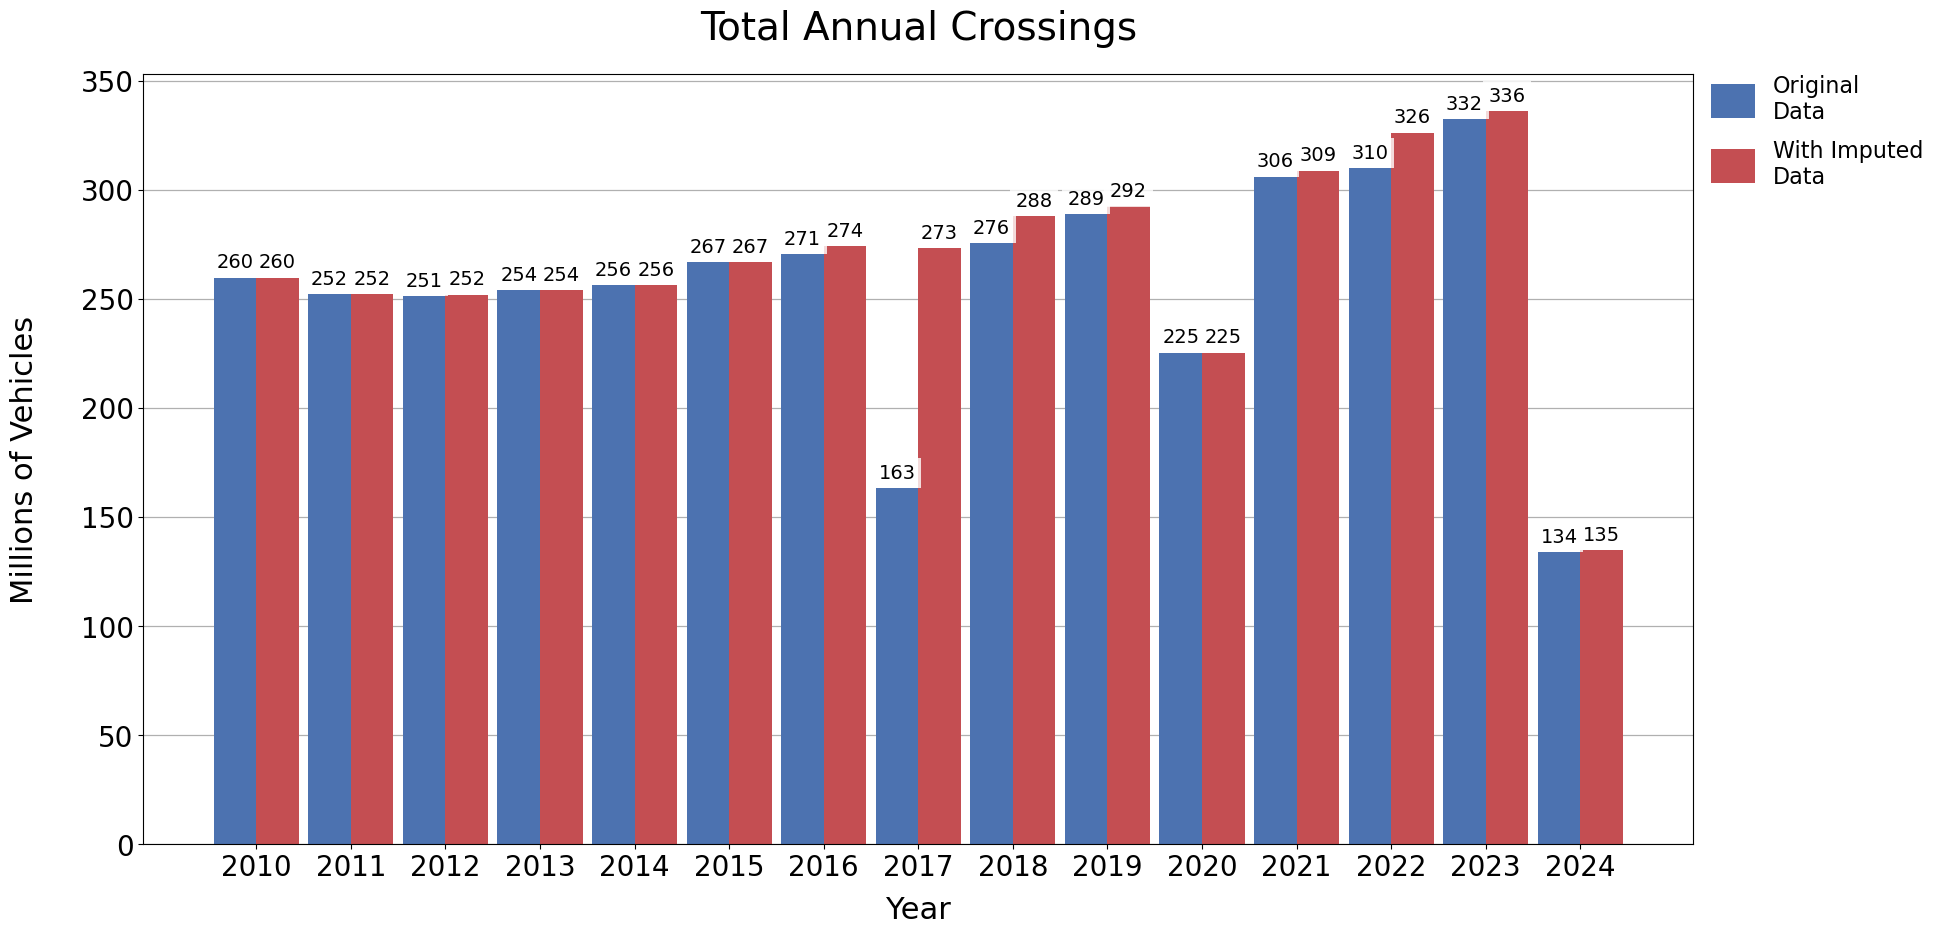

In [31]:
viz.grouped_bar_chart(
    annual_crossings,
    title="Total Annual Crossings",
    ylabel="Millions of Vehicles",
    xlabel="Year",
    ylabel_rotation="vertical",
    figsize=(20, 10),
    bar_fontsize=14,
    bar_padding=4,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    legend_labels=src.strings.add_line_breaks(["Original Data", "With Imputed Data"]),
    legend_args={"legend_handleheight": 2.0, "legend_bbox": (1.025, 0.9)},
)

In [32]:
len(vehicle_index[vehicle_index == 0]), len(vehicle_index[vehicle_index < 100])

(14, 42)

There are several one-hour windows where there is zero traffic on the 9 MTA bridges and tunnels in NYC. These appear to correspond to time changes for daylight savings time or Hurricane Sandy (2012-10-30) where the MTA bridges and tunnels may have been closed or did not record crossings. 

In [33]:
vehicle_index[vehicle_index == 0]

2010-03-14 02:00:00    0
2012-03-11 02:00:00    0
2012-10-30 01:00:00    0
2012-10-30 02:00:00    0
2012-10-30 03:00:00    0
2012-10-30 04:00:00    0
2012-10-30 05:00:00    0
2012-10-30 06:00:00    0
2012-10-30 07:00:00    0
2012-10-30 08:00:00    0
2013-03-10 02:00:00    0
2014-03-09 02:00:00    0
2015-03-08 02:00:00    0
2016-03-13 02:00:00    0
Name: Sum Vehicles, dtype: int64

In [34]:
vehicle_index.quantile(0.0002), vehicle_index.quantile(0.0005)

(26.531200000000005, 630.7560000000001)

The dates for extremely low crossing numbers tend to correspond to major weather events.  2011-08-28 was Hurricane Irene. 2012-10-29 / 2012-10-30 was Hurricane Sandy. 2015-01-26/27 and 2016-01-23/24 were blizzards.

In [35]:
vehicle_index[vehicle_index.between(200, 1000)]

2010-12-27 03:00:00    771
2011-03-13 02:00:00    378
2011-08-28 01:00:00    625
2011-08-28 02:00:00    450
2011-08-28 03:00:00    318
2011-08-28 04:00:00    347
2011-08-28 05:00:00    445
2011-08-28 06:00:00    779
2011-08-28 07:00:00    887
2011-08-28 08:00:00    869
2011-08-28 09:00:00    970
2012-10-29 19:00:00    608
2012-10-29 20:00:00    462
2012-10-30 10:00:00    259
2012-10-30 11:00:00    733
2015-01-26 23:00:00    926
2015-01-27 00:00:00    609
2015-01-27 01:00:00    398
2015-01-27 02:00:00    397
2015-01-27 03:00:00    289
2015-01-27 04:00:00    355
2015-01-27 05:00:00    738
2016-01-23 17:00:00    902
2016-01-23 18:00:00    777
2016-01-23 19:00:00    789
2016-01-23 20:00:00    714
2016-01-23 21:00:00    620
2016-01-23 22:00:00    655
2016-01-23 23:00:00    626
2016-01-24 00:00:00    674
2016-01-24 01:00:00    413
2016-01-24 02:00:00    409
2016-01-24 03:00:00    335
2016-01-24 04:00:00    480
2016-01-24 05:00:00    812
Name: Sum Vehicles, dtype: int64

We create a traffic index where the minimum value of vehicle crossings per hour corresponds to the .05 percentile of hourly crossings. This is done to prevent any divide by zero errors.

In [36]:
estimated_min = int(vehicle_index.quantile(0.0005))
vehicle_index[vehicle_index < estimated_min] = estimated_min

In [37]:
vehicle_index.min(), vehicle_index.max()

(630, 126084)

In [38]:
vehicle_index = pd.DataFrame(vehicle_index)

In [39]:
vehicle_index.to_pickle(PROCESSED_DATA_LOC)